### Use TCGA expression data to train RB1 signature

In [14]:
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

import helper

%matplotlib inline

### 1. TCGA expression data and RB1 mutation data preprocessing 

In [7]:
mRNA_file = "./data/TCGA/mRNA.tsv"
mutation_file = "./data/TCGA/RB1_maf.tsv"
clinical_file = "./data/TCGA/clinical.tsv"
copynumber_file = "./data/TCGA/RB1_copynumber.tsv"

In [46]:
mRNA_df = pd.read_csv(mRNA_file, delimiter="\t")
# dropna
mRNA_df.dropna(inplace=True)
# transpose
mRNA_df_transposed = mRNA_df.set_index("gene_id").transpose()
# take log
mRNA_df_transposed_log = mRNA_df_transposed.applymap(lambda x:np.log(x+1))

# save preprocessed mRNA (dropna, transpose, log)
mRNA_df_transposed_log.index.name = "sample_id"
# mRNA_df_transposed_log.to_csv("./data/TCGA/mRNA_transpose_log.csv")

# quantile normalization
mRNA_df_transposed_quantile = mRNA_df_transposed.rank(axis=1, pct=True)
mRNA_df_transposed_quantile.to_csv("./data/TCGA/mRNA_transpose_quantile.csv")

In [8]:
# get just prostate tissue
def get_label(barcode, dic):
    patient_id = barcode[:12]
    if patient_id in dic:
        return dic[patient_id]
    else:
        return None

    
for norm in ["log", "quantile"]:
    mRNA_df = pd.read_csv("./data/TCGA/mRNA_transpose_{0}.csv".format(norm))
    clinical_df = pd.read_csv(clinical_file, delimiter="\t", 
                              encoding="ISO-8859-1", low_memory=False)
    tissue_dict = dict(zip(clinical_df.bcr_patient_barcode, clinical_df.acronym))
    label_df = pd.DataFrame(index=mRNA_df.sample_id)
    label_df["tissue"] = list(mRNA_df.sample_id.apply(lambda x: get_label(x, tissue_dict)))
    prostate_samples = list(label_df[label_df.tissue == "PRAD"].index)
    prostate_mRNA_df = mRNA_df[mRNA_df.sample_id.isin(prostate_samples)]
    prostate_mRNA_df.to_csv("./data/TCGA/mRNA_transpose_{0}_prostate.csv".format(norm), index=None)

In [11]:
# get RB1 mutation status from MAF file
def is_RB1_mutated(variant_classification):
    if variant_classification in ["Silent", "3'UTR", "Intron"]:
        return 0
    else:
        return 1
    
def add_to_label(barcode):
    if barcode[:15] not in RB1_dict.keys():
        return 0
    else:
        return RB1_dict[barcode[:15]]
    
    
rb_df = pd.read_csv(mutation_file, delimiter="\t")
rb_df["RB1_mutation"] = rb_df.Variant_Classification.apply(is_RB1_mutated)
RB1_dict = dict(zip([i[:15] for i in rb_df.Tumor_Sample_Barcode], 
                    rb_df.RB1_mutation))

assert(list(label_df.index) == list(mRNA_df.sample_id))
label_df["RB_mutation"] = list(map(add_to_label, list(label_df.index)))
label_df.RB_mutation.value_counts()

0    10684
1      385
Name: RB_mutation, dtype: int64

In [13]:
# get RB1 mutation from copy number file
def add_RB_cnv_info(barcode):
    sample_id = barcode[:15]
    if sample_id not in RB1_cnv_dict.keys():
        return 0
    else:
        copynumber = RB1_cnv_dict[sample_id]
        if copynumber == -2:
            return 1
        else: return 0

df_cnv = pd.read_csv(copynumber_file, delimiter="\t")
sample_cols = [i for i in df_cnv.columns if "TCGA" in i]
df_cnv = df_cnv[sample_cols]
RB1_cnv_dict = dict(zip([i[:15] for i in df_cnv.columns], df_cnv.iloc[0]))
label_df["RB_biallelic_loss"] = list(map(add_RB_cnv_info, list(label_df.index)))
label_df.RB_biallelic_loss.value_counts()

0    10769
1      300
Name: RB_biallelic_loss, dtype: int64

In [23]:
label_df["RB_combined"] = 0
label_df.loc[(label_df.RB_mutation==1)|(label_df.RB_biallelic_loss==1), "RB_combined"] = 1
label_df.rb_combined.value_counts()

0    10404
1      665
Name: rb_combined, dtype: int64

In [24]:
label_df[label_df.tissue=="PRAD"]["RB_combined"].value_counts()

0    502
1     48
Name: RB_combined, dtype: int64

In [29]:
label_df.to_csv("./data/TCGA/RB_labels.csv")

### 2. Training Signature with Logistic Regression (with L1 regularization)
#### 2.1 with just prostate sample
 * With RB mutation data as label
 * With RB copy number data as label
 * With both RB mutation and copy number data as label

In [61]:
def save_signature(clf, X, y, filename="", genes=None):
    clf.fit(X, y)
    gene_coef = clf.coef_[0]
    signature_df = pd.DataFrame(index=genes, columns=None, data=gene_coef)
    signature_df.to_csv(filename, header=None)

In [30]:
label_df = pd.read_csv("./data/TCGA/RB_labels.csv", index_col="sample_id")
X_prostate = pd.read_csv("./data/TCGA/mRNA_transpose_quantile_prostate.csv", index_col="sample_id")
label_prostate = label_df[label_df.tissue=="PRAD"].copy()
assert(list(X_prostate.index) == list(label_prostate.index))

In [44]:
# mutation signature
classifiers = {"LR": LogisticRegression(penalty="l1", C=0.3, class_weight="balanced")}
X = X_prostate.as_matrix()
y_rb_mutation = label_prostate["RB_mutation"].as_matrix()
result_df = helper.stratified_cv(X, y, classifiers["LR"], folds=3, random_state=0)
print("-------------")
print(result_df.mean(axis=1))

1,2,3,-------------
train AUC    0.931774
test AUC     0.720868
dtype: float64


In [62]:
# save signature
save_signature(classifiers["LR"], X, y_rb_mutation, 
               filename="./data/TCGA/RBsig_TCGA_prostate_mutation.csv",
               genes=[i.split("|")[0] for i in X_prostate.columns])

In [67]:
for label in ["RB_biallelic_loss", "RB_combined"]:
    print(label)
    classifiers = {"LR": LogisticRegression(penalty="l1", C=0.3, class_weight="balanced")}
    X = X_prostate.as_matrix()
    y = label_prostate[label].as_matrix()
    result_df = helper.stratified_cv(X, y, classifiers["LR"], folds=3, random_state=0)
    print("-------------")
    print(result_df.mean(axis=1))
    save_signature(classifiers["LR"], X, y, 
                   filename="./data/TCGA/RBsig_TCGA_prostate_{0}.csv".format(label),
                   genes=[i.split("|")[0] for i in X_prostate.columns])

RB_biallelic_loss
1,2,3,-------------
train AUC    0.928155
test AUC     0.733929
dtype: float64
RB_combined
1,2,3,-------------
train AUC    0.931774
test AUC     0.720868
dtype: float64


### 2. Training Signature with Logistic Regression (with L1 regularization)
#### 2.2 with all TCGA samples
 * With RB mutation data as label
 * With RB copy number data as label
 * With both RB mutation and copy number data as label

In [9]:
def save_signature(clf, X, y, filename="", genes=None):
    clf.fit(X, y)
    gene_coef = clf.coef_[0]
    signature_df = pd.DataFrame(index=genes, columns=None, data=gene_coef)
    signature_df.to_csv(filename, header=None)

In [7]:
label_df = pd.read_csv("./data/TCGA/RB_labels.csv", index_col="sample_id")
X = pd.read_csv("./data/TCGA/mRNA_transpose_quantile.csv", index_col="sample_id")

In [8]:
for label in ["RB_mutation", "RB_biallelic_loss", "RB_combined"]:
    print(label)
    clr= LogisticRegression(penalty="l1", C=0.1, class_weight="balanced")
    y = label_df[label].as_matrix()
    result_df = helper.stratified_cv(X.as_matrix(), y, clr, 
                                     folds=5, random_state=0)
    print("-------------")
    print(result_df.mean(axis=1))
    save_signature(clr, X, y, 
                   filename="./data/TCGA/RBsig_TCGA_{0}.csv".format(label),
                   genes=[i.split("|")[0] for i in X.columns])

RB_mutation
1,2,3,4,5,-------------
train AUC    0.953511
test AUC     0.816416
dtype: float64
RB_biallelic_loss
1,2,3,4,5,-------------
train AUC    0.959233
test AUC     0.863878
dtype: float64
RB_combined
1,2,3,4,5,-------------
train AUC    0.930896
test AUC     0.824142
dtype: float64


#### 2.3 train with TCGA non-prostate samples and test on prostate samples
 * With RB mutation data as label
 * With RB copy number data as label
 * With both RB mutation and copy number data as label

In [18]:
label_not_prostate = label_df[label_df.tissue!="PRAD"].copy()
X_not_prostate = X.loc[label_not_prostate.index].copy()
label_prostate = label_df[label_df.tissue=="PRAD"].copy()
X_prostate = X.loc[label_prostate.index]

for label in ["RB_mutation", "RB_biallelic_loss", "RB_combined"]:
    print(label)
    clf= LogisticRegression(penalty="l1", C=0.05, class_weight="balanced")
    X_train = X_not_prostate.as_matrix()
    X_test = X_prostate.as_matrix()
    y_train = label_not_prostate[label].as_matrix()
    y_test = label_prostate[label].as_matrix()
    clf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, clf.predict(X_train))
    test_auc = roc_auc_score(y_test, clf.predict(X_test))
    print("train auc:", train_auc)
    print("test auc:", test_auc)
    print("-------------")

RB_mutation
train auc: 0.896896548696
test auc: 0.666666666667
-------------
RB_biallelic_loss
train auc: 0.941785978652
test auc: 0.532565562457
-------------
RB_combined
train auc: 0.886546093368
test auc: 0.518841301461
-------------


### 3. Apply RB signatures to WCDT data

In [23]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
path_call = "./data/WCDT_final_path_call.csv"
WCDT_df = pd.read_csv(WCDT_mRNA, delimiter="\t", index_col="gene_id").T.rank(axis=1, pct=True)
path_call_df = pd.read_csv(path_call, index_col="Patient ID")
example_sig = pd.read_csv("./data/TCGA/RBsig_TCGA.csv", header=None)
common_genes = sorted(list(set(example_sig[0]).intersection(set(WCDT_df.columns))))

In [24]:
RBscores = pd.DataFrame(index=WCDT_df.index)
for sig_type in ["TCGA", "TCGA_prostate"]:
    for rb_type in ["mutation", "biallelic_loss", "combined"]:
        filename = "./data/TCGA/RBsig_{0}_RB_{1}.csv".format(sig_type, rb_type)
        sig_df = pd.read_csv(filename, header=None)
        WCDT_RBscore = np.dot(WCDT_df[common_genes].as_matrix(), 
                              sig_df.set_index(0).loc[common_genes].as_matrix())
        RBscores["{0}_RB_{1}".format(sig_type, rb_type)] = WCDT_RBscore

In [27]:
RBscores = RBscores.loc[path_call_df.index]
RBscores.sample(5)

,TCGA_RB_mutation,TCGA_RB_biallelic_loss,TCGA_RB_combined,TCGA_prostate_RB_mutation,TCGA_prostate_RB_biallelic_loss,TCGA_prostate_RB_combined
Patient ID,,,,,,
DTB-098Pro2,-4.441498,-3.868290,-4.060287,-2.553846,-8.519989,-7.697023
DTB-007,0.310463,2.273766,2.447453,-0.830900,-3.377967,-3.800560
DTB-137,-2.609995,-0.479446,-1.273348,-1.872322,-3.009054,-3.244979
DTB-005,-1.875184,-1.112305,-0.650276,-2.834015,-5.804009,-5.604855
DTB-176,-2.722198,0.050104,-0.193169,-4.339332,-5.041210,-5.129596


In [28]:
path_call_df["Path Classification"].value_counts()

Not small cell    90
Small Cell        14
Unclassified       8
Mixed              7
Name: Path Classification, dtype: int64

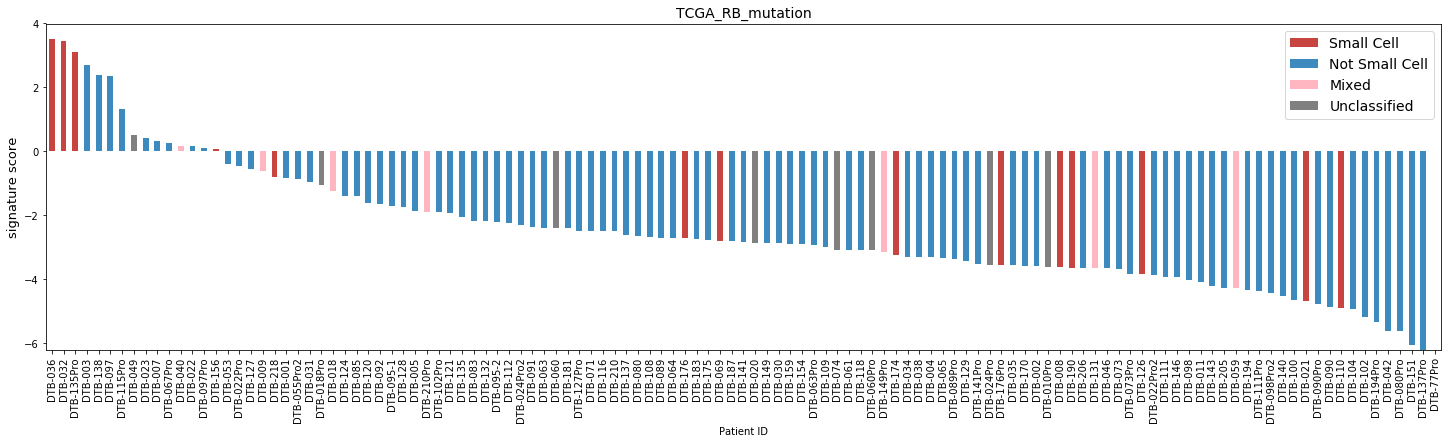

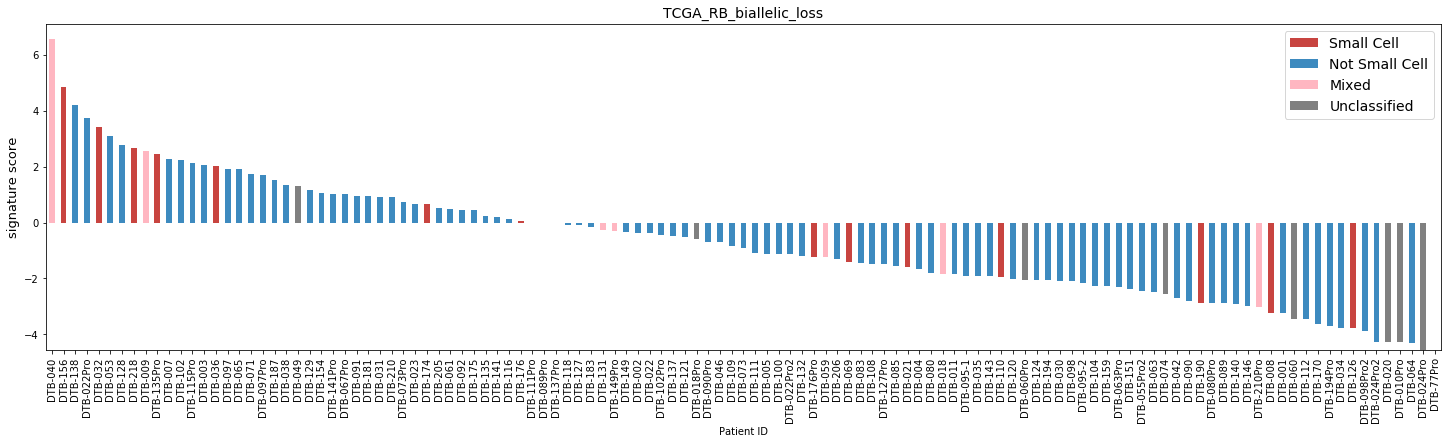

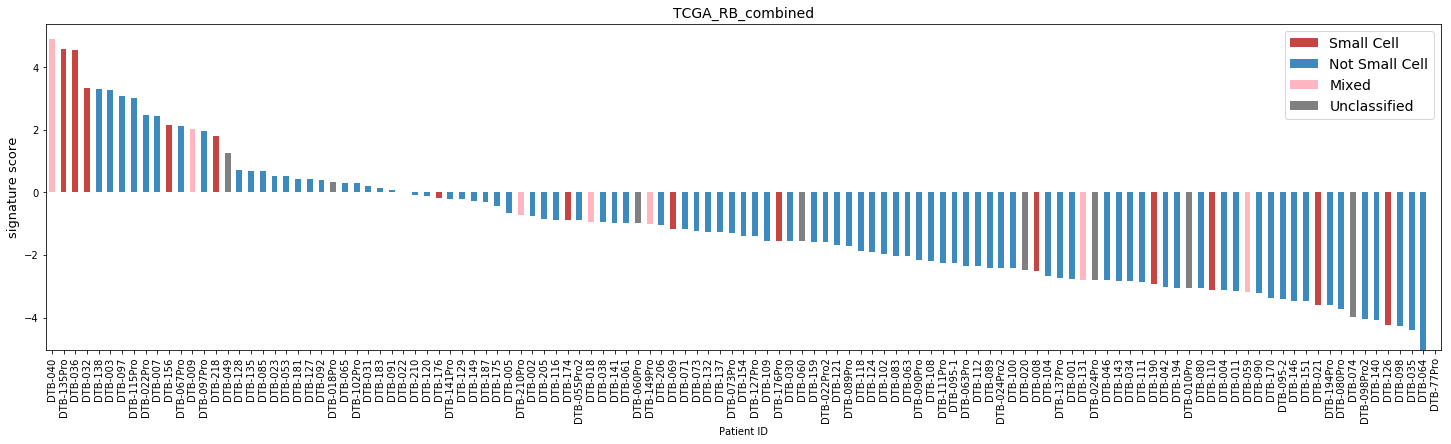

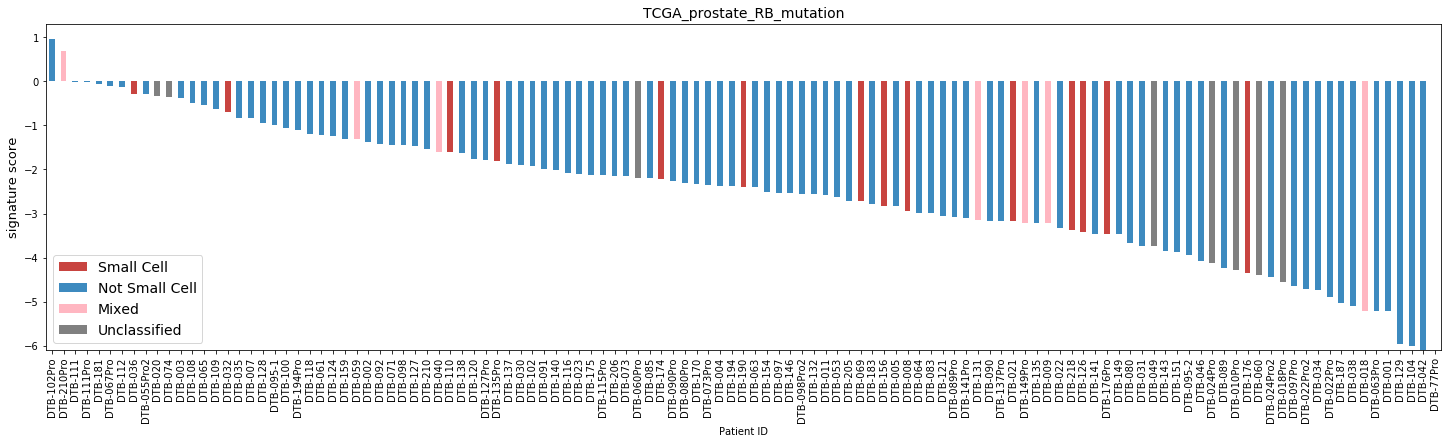

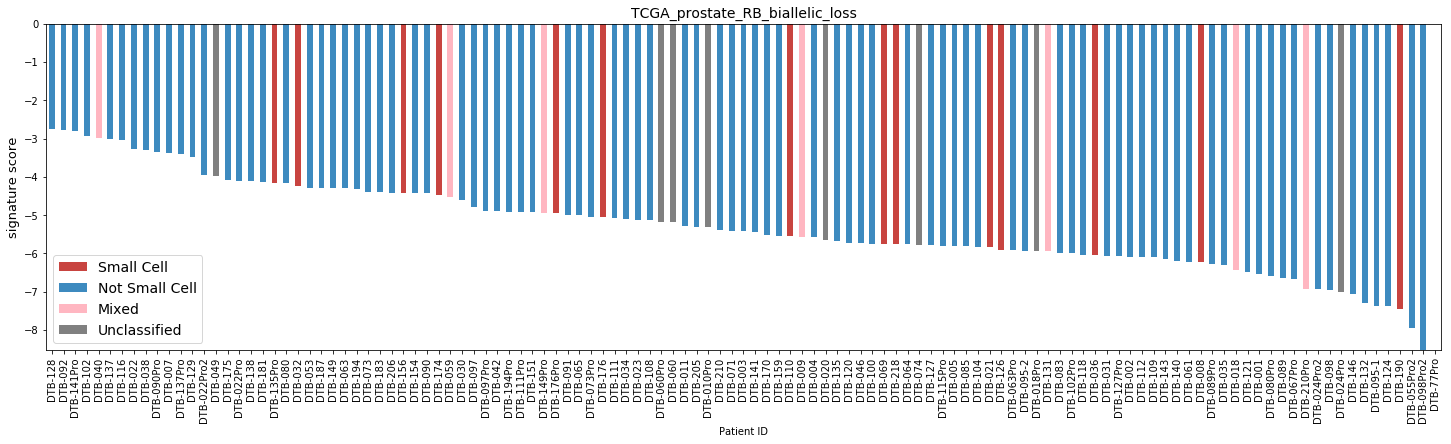

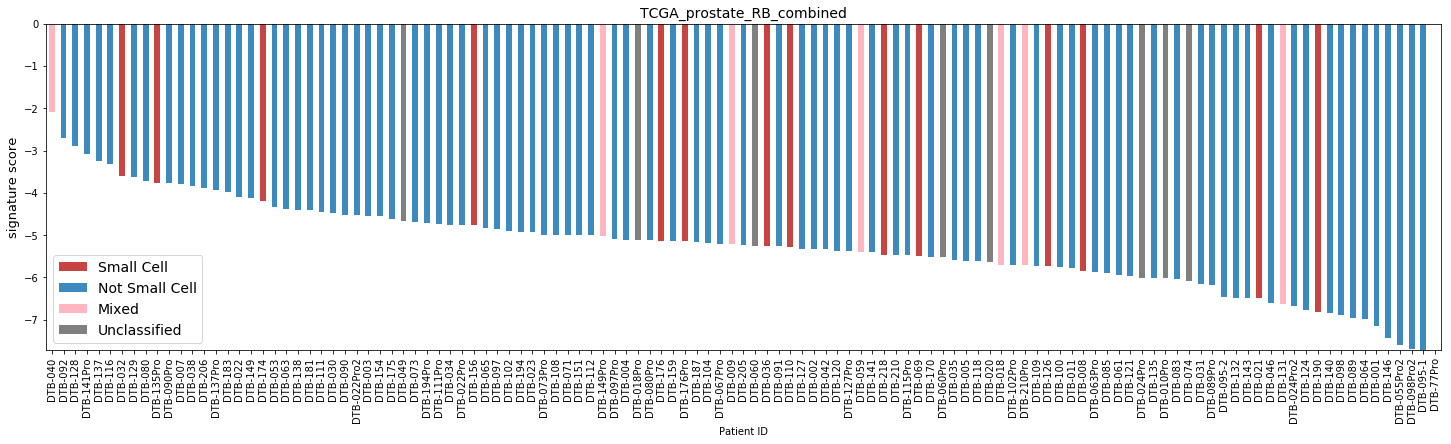

In [29]:
assert(sorted(list(RBscores.index)) == sorted(list(path_call_df.index)))

for sig in RBscores.columns:
    RBscores.sort_values(sig, ascending=False, inplace=True)
    small_cell = list(path_call_df[path_call_df["Path Classification"] == "Small Cell"].index)
    mixed = list(path_call_df[path_call_df["Path Classification"] == "Mixed"].index)
    unclassified = list(path_call_df[path_call_df["Path Classification"] == "Unclassified"].index)
    not_small_cell = list(path_call_df[path_call_df["Path Classification"] == "Not small cell"].index)
    colors = dict(zip(small_cell + not_small_cell + mixed + unclassified, 
                      ["#C84440"] * len(small_cell) + ["#3D8ABF"] * len(not_small_cell) + 
                      ["#ffb6c1"] * len(mixed) + ["#808080"] * len(unclassified)))
    fig, ax= plt.subplots()
    fig.set_size_inches(25,6)
    RBscores[sig].plot.bar(ax=ax, color=[colors[i] for i in RBscores.index])
    ax.set_ylabel("signature score", fontsize=13)
    red_proxy = plt.Rectangle((0, 0), 1, 1, fc="#C84440")
    pink_proxy = plt.Rectangle((0, 0), 1, 1, fc="#3D8ABF")
    blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="#ffb6c1")
    grey_proxy = plt.Rectangle((0, 0), 1, 1, fc="#808080")
    ax.legend([red_proxy,pink_proxy,blue_proxy,grey_proxy],
              ['Small Cell','Not Small Cell','Mixed','Unclassified'], fontsize=14)
    ax.set_title("{0}".format(sig), fontsize=14)
    fig.savefig("./{0}_scores.png".format(sig), dpi=200)

### 3. Color the above with Verena's cluster assignment

### 4. Use Signature from Christopher McNair
* It's a list of 80 genes with equal weight

In [59]:
mcnair_sig = "./data/McNair_RB_loss_sig.txt"
mcnair_sig_genes = list(pd.read_csv("./data/McNair_RB_loss_sig.txt", header=None)[0])
WCDT_df = pd.read_csv(WCDT_mRNA, delimiter="\t", index_col="gene_id").T
WCDT_df_rank = pd.read_csv(WCDT_mRNA, delimiter="\t", index_col="gene_id").T.rank(axis=1, pct=True)

In [60]:
common_genes = list(set(mcnair_sig_genes).intersection(set(WCDT_df.columns)))
RBscores = pd.DataFrame(index=WCDT_df.index)
RBscores["McNair_RB_sig(raw WCDT data)"] = WCDT_df[common_genes].sum(axis=1)
RBscores["McNair_RB_sig(quantile WCDT data)"] = WCDT_df_rank[common_genes].sum(axis=1)
RBscores = RBscores.loc[path_call_df.index]

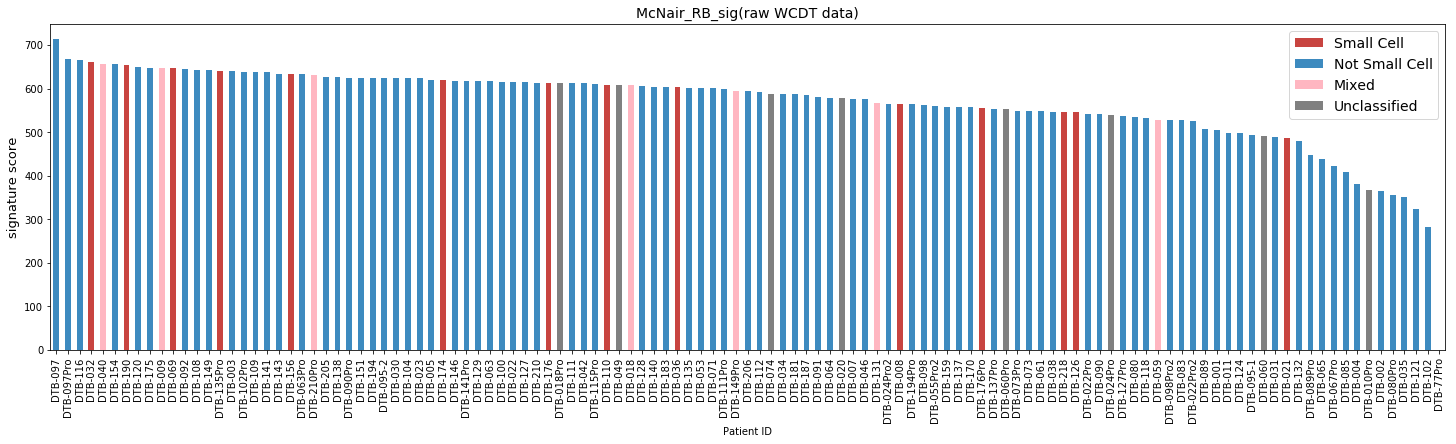

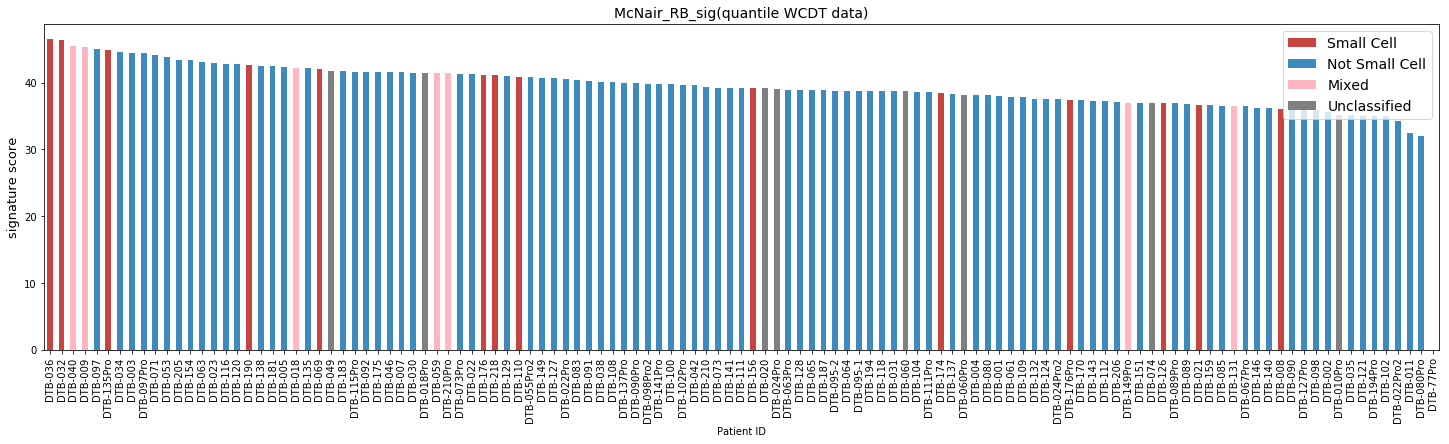

In [61]:
assert(sorted(list(RBscores.index)) == sorted(list(path_call_df.index)))

for sig in RBscores.columns:
    RBscores.sort_values(sig, ascending=False, inplace=True)
    small_cell = list(path_call_df[path_call_df["Path Classification"] == "Small Cell"].index)
    mixed = list(path_call_df[path_call_df["Path Classification"] == "Mixed"].index)
    unclassified = list(path_call_df[path_call_df["Path Classification"] == "Unclassified"].index)
    not_small_cell = list(path_call_df[path_call_df["Path Classification"] == "Not small cell"].index)
    colors = dict(zip(small_cell + not_small_cell + mixed + unclassified, 
                      ["#C84440"] * len(small_cell) + ["#3D8ABF"] * len(not_small_cell) + 
                      ["#ffb6c1"] * len(mixed) + ["#808080"] * len(unclassified)))
    fig, ax= plt.subplots()
    fig.set_size_inches(25,6)
    RBscores[sig].plot.bar(ax=ax, color=[colors[i] for i in RBscores.index])
    ax.set_ylabel("signature score", fontsize=13)
    red_proxy = plt.Rectangle((0, 0), 1, 1, fc="#C84440")
    pink_proxy = plt.Rectangle((0, 0), 1, 1, fc="#3D8ABF")
    blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="#ffb6c1")
    grey_proxy = plt.Rectangle((0, 0), 1, 1, fc="#808080")
    ax.legend([red_proxy,pink_proxy,blue_proxy,grey_proxy],
              ['Small Cell','Not Small Cell','Mixed','Unclassified'], fontsize=14)
    ax.set_title("{0}".format(sig), fontsize=14)
    fig.savefig("./{0}_scores.png".format(sig), dpi=200)